# Scipy

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
import idaes


In [3]:
def load_model_data(data_file, job_title):
    """Loads time series data and returns it along with job folder path and CRC path check."""
    # CRC path check
    crc_path = f'/afs/crc.nd.edu/user/s/scini/github_data/multicell/{data_file}.csv'
    path_check = os.path.exists(crc_path)

    # Set base path based on location
    if path_check:
        print("This is the CRC.")
        base_folder_path = '/afs/crc.nd.edu/user/s/scini/github_data/multicell'
    elif os.name == 'posix':
        print("This is a Unix/Linux or Mac system.")
        base_folder_path = r'/Users/scini/Library/CloudStorage/Box-Box/ZartmanLabGroupFolder/Zartman_Dowling/Stephen/data_store/multcell_sims'
    elif os.name == 'nt':
        print("This is a Windows system.")
        base_folder_path = r"C:\Users\steph\Box\ZartmanLabGroupFolder\Zartman_Dowling\Stephen\data_store\multcell_sims"
    else:
        raise OSError("Unsupported or unknown OS.")

    # Load CSV
    data_path = os.path.join(base_folder_path, f"{data_file}.csv")
    if not os.path.isfile(data_path):
        raise FileNotFoundError(f"Could not find file: {data_path}")
    
    mult_data = pd.read_csv(data_path)

    # Map columns
    if data_file == "multcell_2025_03_25_1":
        time_data = mult_data['Time (min)']
        cell0 = mult_data['cell0']
    elif data_file == "singlecell_2025_03_23_1":
        time_data = mult_data['Time']
        cell0 = mult_data['Cytosol']
    elif data_file == "wingdisc_data_2024":
        time_data = mult_data['time']
        cell0 = mult_data['cell_27']
    else:
        raise ValueError("Invalid data_file specified.")


    time_data = time_data[::10] * 60
    cell0 = cell0[::10]

    # Convert to NumPy
    time_data = time_data.to_numpy()
    cell0 = cell0.to_numpy()

    # Create job-specific output folder
    folder_path = os.path.join(base_folder_path, job_title)
    os.makedirs(folder_path, exist_ok=True)

    print(f"Loaded {data_file}. Time range: {time_data[0]} to {time_data[-1]}")
    return time_data, cell0, folder_path, path_check

In [4]:
data_file = "multcell_2025_03_25_1"
job_title = "multicell_GJ_simulation"
time_data, cell0, folder_path, path_check = load_model_data(data_file, job_title)

This is a Windows system.
Loaded multcell_2025_03_25_1. Time range: 0.0 to 3598.0


In [5]:

class PouchModelScipy:
    def __init__(self, 
                 laplacian_matrix, 
                 dt=0.2, 
                 sim_time=3600, 
                 param_dict=None,
                 t_eval_boolean=False):
        self.dt = dt
        self.sim_time = sim_time
        if t_eval_boolean:
            self.t_eval = np.arange(0, sim_time, dt)

        # Initialize laplacian matrix
        self.laplacian = laplacian_matrix
        # Number of cells
        self.n_cells = laplacian_matrix.shape[0]

        # Parameters (could be estimated)
        self.default_params = {
            'D_p': 0.005,
            'D_c_ratio': 0.1,
            "K_PLC": 0.2,
            "K_5": 0.66,
            "k_1": 1.11,
            "k_a": 0.08,
            "k_p": 0.13,
            "k_2": 0.0203,
            "V_SERCA": 0.9,
            "K_SERCA": 0.1,
            "c_tot": 2,
            "beta": 0.185,
            "k_i": 0.4,
            "tau_max": 800,
            "k_tau": 1.5,
            "VPLC": 1.1

        }

        if param_dict:
            self.default_params.update(param_dict)

    def pouch_odes(self, t, y, theta):
        # Unpack variables (flattened: all Ca, then IP3, then S, then R)
        n = self.n_cells
        Ca, IP3, R = np.split(y, 3)

        # Extract parameters
        D_c_ratio = theta['D_c_ratio']
        D_p = theta['D_p']
        k_1 = theta['k_1']
        k_2 = theta['k_2']
        V_SERCA = theta['V_SERCA']
        K_SERCA = theta['K_SERCA']
        K_PLC = theta['K_PLC']
        K_5 = theta['K_5']
        k_a = theta['k_a']
        k_p = theta['k_p']
        beta = theta['beta']
        c_tot = theta['c_tot']
        k_tau = theta['k_tau']
        tau_max = theta['tau_max']
        k_i = theta['k_i']
        VPLC = theta['VPLC']

        # Laplacians using adjacency matrix
        ca_lap = np.zeros_like(Ca)
        ip3_lap = np.zeros_like(IP3)

        D_c = D_p * D_c_ratio
        ca_lap = D_c * self.laplacian @ Ca
        ip3_lap = D_p * self.laplacian @ IP3

        # S is algebraic, not a derivative
        S_algebraic = (c_tot - Ca) / beta

        # ODEs
        J_IP3R = k_1 * ((R * Ca * IP3) / (k_a + Ca) / (k_p + IP3))**3
        J_SERCA = V_SERCA * Ca**2 / (Ca**2 + K_SERCA**2)
        dCa_dt = ca_lap + (J_IP3R + k_2) * (S_algebraic - Ca) - J_SERCA

        V_PLC = VPLC*(Ca**2) / (Ca**2 + K_PLC**2)
        dIP3_dt = ip3_lap + V_PLC - K_5 * IP3
        dR_dt = ((k_tau**4 + Ca**4) / (tau_max * k_tau**4)) * (1 - R * (k_i + Ca) / k_i)

        # Return derivatives, but S is replaced by its algebraic value
        return np.concatenate([dCa_dt, dIP3_dt, dR_dt])

    def simulate(self, theta_dict=None, y0=None):
        if theta_dict is None:
            theta_dict = self.default_params
        if y0 is None:
            # Initial values: Ca, IP3, S, R
            Ca0 = np.zeros(self.n_cells)
            IP30 = np.zeros(self.n_cells)
            R0 = np.random.uniform(0.5, 0.7, self.n_cells)
            y0 = np.concatenate([Ca0, IP30, R0])

        sol = solve_ivp(
            fun=lambda t, y: self.pouch_odes(t, y, theta_dict),
            t_span=(0, self.sim_time),
            y0=y0,
            t_eval=self.t_eval if hasattr(self, 't_eval') else None,
            method='Radau',
        )
        return sol
        


In [6]:
def residuals(theta_array, model: PouchModelScipy, data):
    # Map theta_array to names
    param_names = []
    theta_dict = model.default_params.copy()
    theta_dict.update({k: v for k, v in zip(param_names, theta_array)})

    # Simulate
    sol = model.simulate(theta_dict)
    Ca_sim = sol.y[:model.n_cells, :]  # Extract calcium

    # Compare to measured (flattened)
    Ca_measured = data.flatten()
    Ca_predicted = Ca_sim.flatten()
    return Ca_predicted - Ca_measured


In [13]:
from scipy.sparse import csc_matrix

def generate_laplacian_grid_with_vertex_matrix(rows, cols):
    """
    Generates the Laplacian matrix for a grid graph and provides vertex positions as a matrix.

    Args:
        rows (int): Number of rows in the grid.
        cols (int): Number of columns in the grid.

    Returns:
        tuple: A tuple containing the Laplacian matrix (sparse CSC) and
               a NumPy matrix of vertex positions.
    """
    n_nodes = rows * cols
    adjacency = np.zeros((n_nodes, n_nodes), dtype=int)
    vertex_matrix = np.zeros((n_nodes, 2))  # Initialize matrix for (x, y) coordinates

    def get_index(r, c):
        if 0 <= r < rows and 0 <= c < cols:
            return r * cols + c
        return -1

    for r in range(rows):
        for c in range(cols):
            current_node = get_index(r, c)
            vertex_matrix[current_node] = [c, -r]  # Assign (x, y) coordinates

            # Connect to neighbors (up, down, left, right)
            neighbors = [
                get_index(r - 1, c),  # Up
                get_index(r + 1, c),  # Down
                get_index(r, c - 1),  # Left
                get_index(r, c + 1),  # Right
            ]

            for neighbor in neighbors:
                if neighbor != -1:
                    adjacency[current_node, neighbor] = 1

    degree = np.diag(np.sum(adjacency, axis=1))
    laplacian = degree - adjacency
    return csc_matrix(laplacian), vertex_matrix, adjacency, degree

# Generate the Laplacian matrix and vertex matrix for a 3x3 grid
rows = 3
cols = 3
laplacian_matrix, vertex_matrix, adj_matrix, deg_matrix = generate_laplacian_grid_with_vertex_matrix(rows, cols)

In [14]:
print("Laplacian Matrix for a 3x3 Grid:")
print(laplacian_matrix.toarray())

print("Adjacency Matrix for a 3x3 Grid:")
print(adj_matrix)


Laplacian Matrix for a 3x3 Grid:
[[ 2 -1  0 -1  0  0  0  0  0]
 [-1  3 -1  0 -1  0  0  0  0]
 [ 0 -1  2  0  0 -1  0  0  0]
 [-1  0  0  3 -1  0 -1  0  0]
 [ 0 -1  0 -1  4 -1  0 -1  0]
 [ 0  0 -1  0 -1  3  0  0 -1]
 [ 0  0  0 -1  0  0  2 -1  0]
 [ 0  0  0  0 -1  0 -1  3 -1]
 [ 0  0  0  0  0 -1  0 -1  2]]
Adjacency Matrix for a 3x3 Grid:
[[0 1 0 1 0 0 0 0 0]
 [1 0 1 0 1 0 0 0 0]
 [0 1 0 0 0 1 0 0 0]
 [1 0 0 0 1 0 1 0 0]
 [0 1 0 1 0 1 0 1 0]
 [0 0 1 0 1 0 0 0 1]
 [0 0 0 1 0 0 0 1 0]
 [0 0 0 0 1 0 1 0 1]
 [0 0 0 0 0 1 0 1 0]]


In [20]:
# Create model and generate synthetic data
model_test = PouchModelScipy(laplacian_matrix=laplacian_matrix)
true_sol = model_test.simulate()
Ca_true = true_sol.y[:model_test.n_cells, :]
noise = 0 # 0.005 * np.random.randn(*Ca_true.shape)
Ca_measured = Ca_true + noise

# Estimate only 3 parameters
param_names = ['D_p', 'D_c', 'K_PLC']
initial_guess = [0.01, 0.001, 0.5]
bounds = ([1e-5, 1e-5, 0.01], [0.1, 0.1, 1.0])

# result = least_squares(
#     residuals,
#     x0=initial_guess,
#     bounds=bounds,
#     args=(model, Ca_measured)
# )

# print("Estimated parameters:", dict(zip(param_names, result.x)))


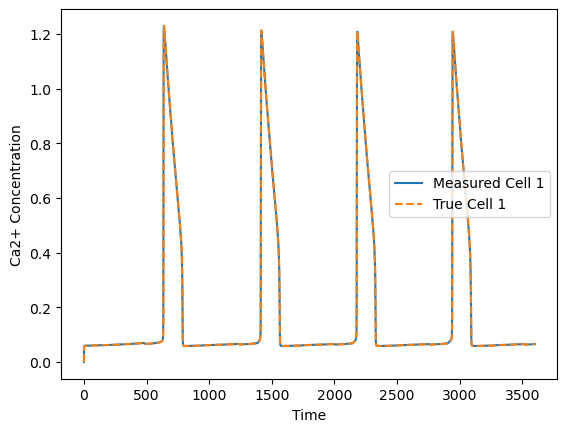

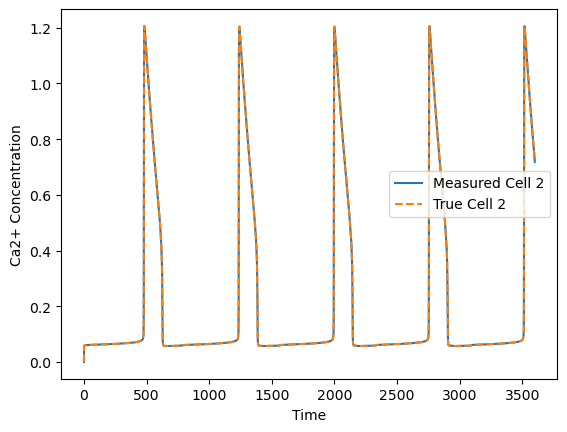

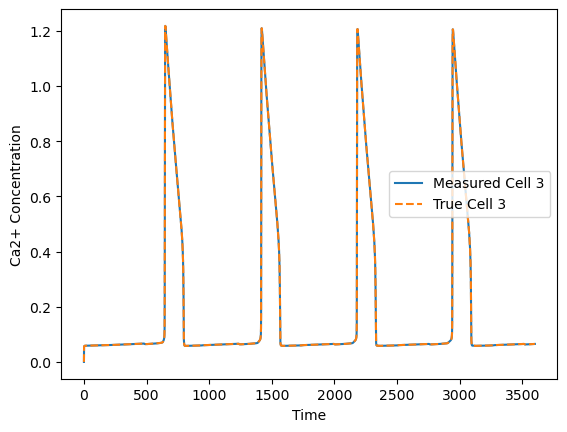

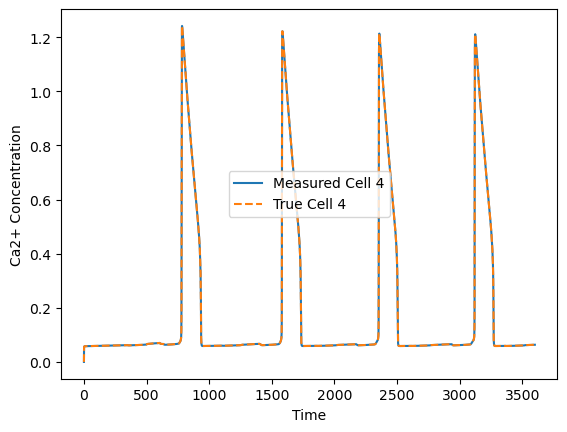

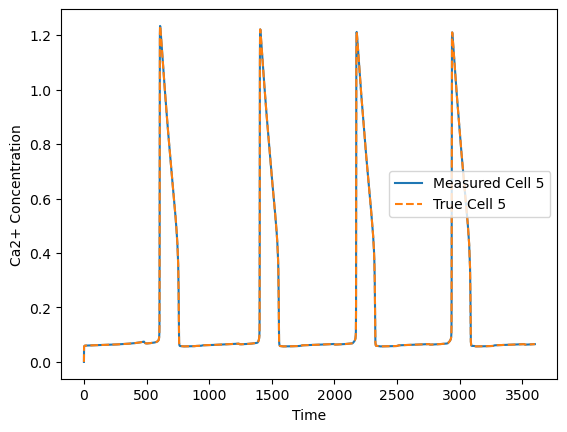

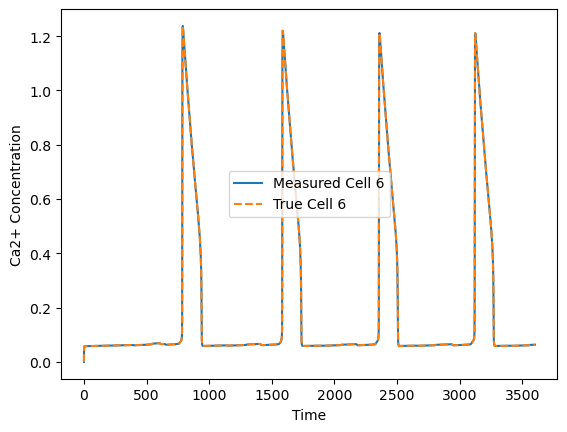

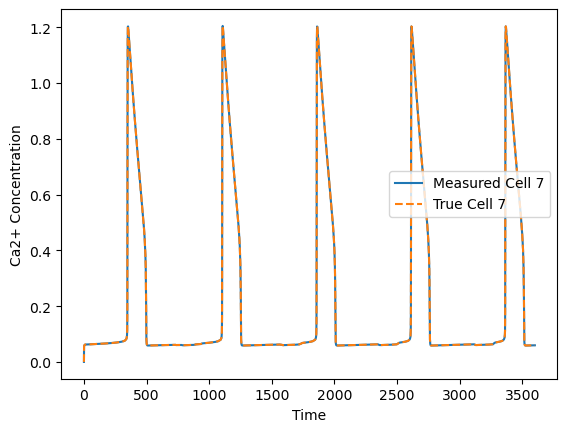

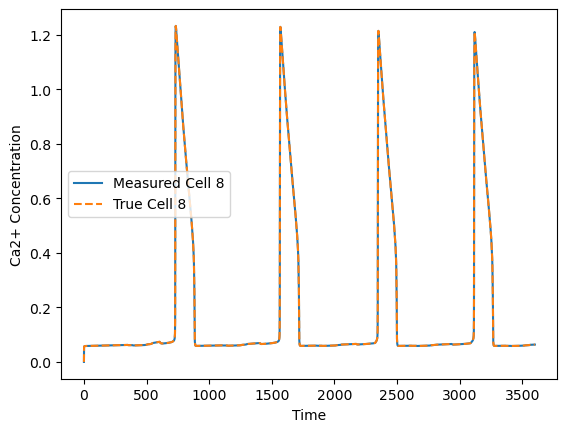

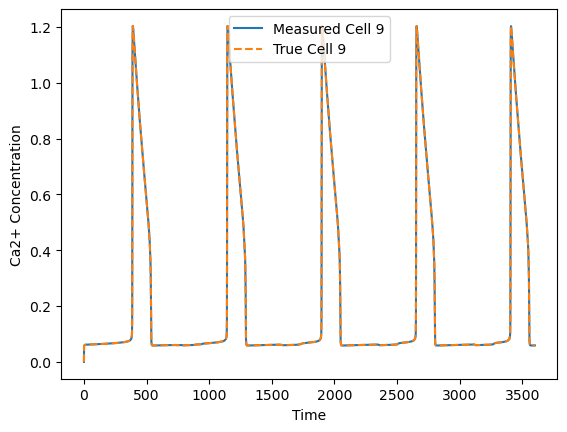

1058 1058 1058


In [21]:
for i in range(model_test.n_cells):
    plt.plot(true_sol.t, Ca_measured[i], label=f'Measured Cell {i+1}')
    plt.plot(true_sol.t, true_sol.y[i], label=f'True Cell {i+1}', linestyle='--')
    # plt.xlim(440, 460)
    plt.xlabel('Time'); plt.ylabel('Ca2+ Concentration')
    plt.legend()
    plt.show()

print(len(true_sol.t), len(Ca_measured[i]), len(true_sol.y[i]))


# Pyomo

In [26]:
# Imports for the model
# Import libraries - original
# Adding for pyomo
import pyomo.environ as pyo
import pyomo.dae as dae

# Make as a class
# Create a Pyomo model for the Pouch model

class PouchModelPyomo:
    def __init__(self, time_points, n_cells=10, theta_dict=None, laplacian_matrix=None):
        self.n_cells = n_cells
        self.time_points = time_points
        self.theta_dict = theta_dict
        self.laplacian_matrix = laplacian_matrix

        if self.theta_dict is None:
            self.theta_dict = {
            'D_p': 0.001,
            'D_c_ratio': 0.0001,
            "K_PLC": 0.2,
            "K_5": 0.66,
            "k_1": 1.11,
            "k_a": 0.08,
            "k_p": 0.13,
            "k_2": 0.0203,
            "V_SERCA": 0.9,
            "K_SERCA": 0.1,
            "c_tot": 2,
            "beta": 0.185,
            "k_i": 0.4,
            "tau_max": 800,
            "k_tau": 1.5,
            "VPLC": 1.1,
            }

        if self.laplacian_matrix is None:
            # Generate a default Laplacian matrix for a grid graph
            self.laplacian_matrix, _, _, _ = self.generate_laplacian_grid(3, 3)

    def generate_laplacian_grid(self, rows, cols):
        """
        Generates the Laplacian matrix for a grid graph and provides vertex positions as a matrix.
        Args:
        rows (int): Number of rows in the grid.
        cols (int): Number of columns in the grid.
        Returns:
        tuple: A tuple containing the Laplacian matrix (sparse CSC) and
               a NumPy matrix of vertex positions.
        """
        n_nodes = rows * cols
        adjacency = np.zeros((n_nodes, n_nodes), dtype=int)
        vertex_matrix = np.zeros((n_nodes, 2))  # Initialize matrix for (x, y) coordinates

        def get_index(r, c):
            if 0 <= r < rows and 0 <= c < cols:
                return r * cols + c
            return -1

        for r in range(rows):
            for c in range(cols):
                current_node = get_index(r, c)
                vertex_matrix[current_node] = [c, -r]  # Assign (x, y) coordinates

                # Connect to neighbors (up, down, left, right)
                neighbors = [
                    get_index(r - 1, c),  # Up
                    get_index(r + 1, c),  # Down
                    get_index(r, c - 1),  # Left
                    get_index(r, c + 1),  # Right
                ]

                for neighbor in neighbors:
                    if neighbor != -1:
                        adjacency[current_node, neighbor] = 1

        degree = np.diag(np.sum(adjacency, axis=1))
        laplacian = degree - adjacency
        return csc_matrix(laplacian), vertex_matrix, adjacency, degree

    def simulate(self):
        # Create a solver
        solver = pyo.SolverFactory('ipopt')
        results = solver.solve(self.model, tee=True)
        return results

    def create_pouch_model(self):
        model = pyo.ConcreteModel()

        # Time domain
        model.t = dae.ContinuousSet(initialize=self.time_points)

        # Cell indices
        model.cells = pyo.RangeSet(0, self.n_cells - 1)

        # Parameters to estimate
        # model.D_c_ratio = pyo.Param(initialize=self.theta_dict.get('D_c_ratio', 0), mutable=True)
        # Convert to variables and fix all to values from self.theta_dict
        # Convert all parameters to variables and fix them to values from self.theta_dict
        model.D_c = pyo.Var(initialize=self.theta_dict.get('D_c_ratio', 0.0001))
        model.D_c.fix(self.theta_dict.get('D_c_ratio', 0.0001))

        model.D_p = pyo.Var(initialize=self.theta_dict.get('D_p', 0.001))
        model.D_p.fix(self.theta_dict.get('D_p', 0.001))

        model.K_PLC = pyo.Var(initialize=self.theta_dict.get('K_PLC', 0.2))
        model.K_PLC.fix(self.theta_dict.get('K_PLC', 0.2))

        model.K_5 = pyo.Var(initialize=self.theta_dict.get('K_5', 0.66))
        model.K_5.fix(self.theta_dict.get('K_5', 0.66))

        model.k_1 = pyo.Var(initialize=self.theta_dict.get('k_1', 1.11))
        model.k_1.fix(self.theta_dict.get('k_1', 1.11))

        model.k_2 = pyo.Var(initialize=self.theta_dict.get('k_2', 0.0203))
        model.k_2.fix(self.theta_dict.get('k_2', 0.0203))

        model.V_SERCA = pyo.Var(initialize=self.theta_dict.get('V_SERCA', 0.9))
        model.V_SERCA.fix(self.theta_dict.get('V_SERCA', 0.9))

        model.K_SERCA = pyo.Var(initialize=self.theta_dict.get('K_SERCA', 0.1))
        model.K_SERCA.fix(self.theta_dict.get('K_SERCA', 0.1))

        model.k_a = pyo.Var(initialize=self.theta_dict.get('k_a', 0.08))
        model.k_a.fix(self.theta_dict.get('k_a', 0.08))

        model.k_p = pyo.Var(initialize=self.theta_dict.get('k_p', 0.13))
        model.k_p.fix(self.theta_dict.get('k_p', 0.13))

        model.beta = pyo.Var(initialize=self.theta_dict.get('beta', 0.185))
        model.beta.fix(self.theta_dict.get('beta', 0.185))

        model.c_tot = pyo.Var(initialize=self.theta_dict.get('c_tot', 2.0))
        model.c_tot.fix(self.theta_dict.get('c_tot', 2.0))

        model.k_tau = pyo.Var(initialize=self.theta_dict.get('k_tau', 1.5))
        model.k_tau.fix(self.theta_dict.get('k_tau', 1.5))

        model.tau_max = pyo.Var(initialize=self.theta_dict.get('tau_max', 800))
        model.tau_max.fix(self.theta_dict.get('tau_max', 800))

        model.k_i = pyo.Var(initialize=self.theta_dict.get('k_i', 0.4))
        model.k_i.fix(self.theta_dict.get('k_i', 0.4))

        model.VPLC = pyo.Var(initialize=self.theta_dict.get('VPLC', 1.1))
        model.VPLC.fix(self.theta_dict.get('VPLC', 1.1))

        # Variables
        model.Ca = pyo.Var(model.cells, model.t)
        model.IP3 = pyo.Var(model.cells, model.t)
        model.S = pyo.Var(model.cells, model.t)
        model.R = pyo.Var(model.cells, model.t)

        # Variables for diffusion
        model.Ca_diff = pyo.Var(model.cells, model.t, initialize=0.0)
        model.IP3_diff = pyo.Var(model.cells, model.t, initialize=0.0)

        # Derivatives
        model.dCa = dae.DerivativeVar(model.Ca, wrt=model.t)
        model.dIP3 = dae.DerivativeVar(model.IP3, wrt=model.t)
        model.dR = dae.DerivativeVar(model.R, wrt=model.t)

        # Define Laplacian-based diffusion constraints using the provided Laplacian matrix
        lap = self.laplacian_matrix.toarray()
        n_cells = self.n_cells

        # # Laplacian diffusion for Ca
        # def ca_laplacian_rule(m, i, t):
        #     return m.Ca_diff[i, t] == sum(m.D_c * lap[i, j] * m.Ca[j, t] for j in range(n_cells))
        # model.ca_laplacian = pyo.Constraint(model.cells, model.t, rule=ca_laplacian_rule)

        # # Laplacian diffusion for IP3
        # def ip3_laplacian_rule(m, i, t):
        #     return m.IP3_diff[i, t] == sum(m.D_p * lap[i, j] * m.IP3[j, t] for j in range(n_cells))
        # model.ip3_laplacian = pyo.Constraint(model.cells, model.t, rule=ip3_laplacian_rule)

        # Algebraic constraints 
        def alg_S(m, i, t):
            return m.S[i, t] == (m.c_tot - m.Ca[i, t]) / m.beta
        model.alg_S = pyo.Constraint(model.cells, model.t, rule=alg_S)

        # ODEs
        def ode_Ca(m, i, t):
            J_IP3R = m.k_1 * ((m.R[i, t] * m.Ca[i, t] * m.IP3[i, t]) / ((m.k_a + m.Ca[i, t]) * (m.k_p + m.IP3[i, t]))) ** 3
            J_SERCA = m.V_SERCA * m.Ca[i, t] ** 2 / (m.Ca[i, t] ** 2 + m.K_SERCA ** 2)
            return m.dCa[i, t] == (J_IP3R + m.k_2) * (m.S[i, t] - m.Ca[i, t]) - J_SERCA
        model.ode_Ca = pyo.Constraint(model.cells, model.t, rule=ode_Ca)

        def ode_IP3(m, i, t):
            J_PLC = m.VPLC*(m.Ca[i, t] ** 2 / (m.Ca[i, t] ** 2 + m.K_PLC ** 2))
            return m.dIP3[i, t] == J_PLC - m.K_5 * m.IP3[i, t]  
        model.ode_IP3 = pyo.Constraint(model.cells, model.t, rule=ode_IP3)



        def ode_R(m, i, t):
            return m.dR[i, t] == ((m.k_tau ** 4 + m.Ca[i, t] ** 4) / (m.tau_max * m.k_tau ** 4)) * (1 - m.R[i, t] * (m.k_i + m.Ca[i, t]) / m.k_i)
        model.ode_R = pyo.Constraint(model.cells, model.t, rule=ode_R)


        # Fix initial conditions
        for i in model.cells:
            # Initial conditions
            model.Ca[i, 0].fix(0.01)
            model.IP3[i, 0].fix(0.01)
            model.R[i, 0].fix(0.61)

            # # Initial diffusion values
            # model.Ca_diff[i, 0].fix(0.0)
            # model.IP3_diff[i, 0].fix(0.0)
            

        return model 


In [27]:
# Define time points
time_points = np.linspace(0, 360, 20)  # 100 time points over 1 hour

pyomo_class_obj = PouchModelPyomo(time_points, n_cells=9, laplacian_matrix=laplacian_matrix)

# Create the model
pyomo_model = pyomo_class_obj.create_pouch_model()

pyomo_model.pprint()  # Print the model structure for debugging


1 RangeSet Declarations
    cells : Dimen=1, Size=9, Bounds=(0, 8)
        Key  : Finite : Members
        None :   True :   [0:8]

22 Var Declarations
    Ca : Size=180, Index=cells*t
        Key                     : Lower : Value : Upper : Fixed : Stale : Domain
                       (0, 0.0) :  None :  0.01 :  None :  True : False :  Reals
         (0, 18.94736842105263) :  None :  None :  None : False :  True :  Reals
         (0, 37.89473684210526) :  None :  None :  None : False :  True :  Reals
         (0, 56.84210526315789) :  None :  None :  None : False :  True :  Reals
         (0, 75.78947368421052) :  None :  None :  None : False :  True :  Reals
         (0, 94.73684210526315) :  None :  None :  None : False :  True :  Reals
        (0, 113.68421052631578) :  None :  None :  None : False :  True :  Reals
         (0, 132.6315789473684) :  None :  None :  None : False :  True :  Reals
        (0, 151.57894736842104) :  None :  None :  None : False :  True :  Reals
     

In [28]:

# Discretize the model using collocation with Lagrange-Radau
discretizer = pyo.TransformationFactory('dae.collocation')
discretizer.apply_to(pyomo_model, nfe=20, ncp=3, scheme='LAGRANGE-RADAU')

# Solve the model
solver = pyo.SolverFactory('ipopt')
solver.solve(pyomo_model, tee=True)


ipopt


ApplicationError: No executable found for solver 'ipopt'

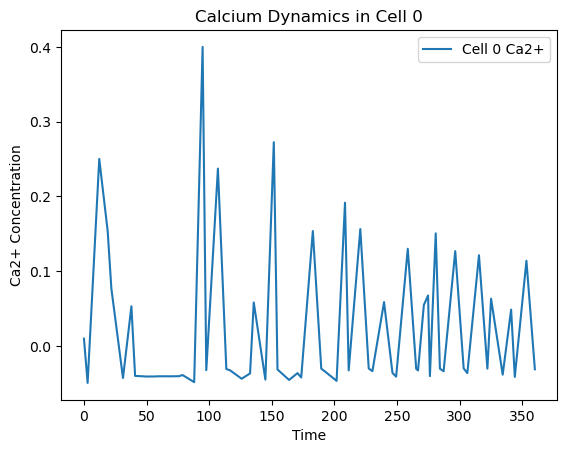

In [ ]:
import matplotlib.pyplot as plt
# Extract and plot Ca2+ concentration for the first cell over time
ca_values = [pyo.value(pyomo_model.Ca[0, t]) for t in pyomo_model.t]
time_points = [pyo.value(t) for t in pyomo_model.t]
plt.plot(time_points, ca_values, label='Cell 0 Ca2+')
plt.xlabel('Time')
plt.ylabel('Ca2+ Concentration')
plt.title('Calcium Dynamics in Cell 0')
plt.legend()
plt.show()

## Not used yet

In [ ]:
import pyomo.contrib.parmest.parmest as parmest
from pyomo.contrib.parmest.experiment import Experiment

exp_list = []
# Create an experiment for the model

exp_list.append(Experiment(
    model=model,
    name='multicell_experiment',
    time_points=time_points,
    n_cells=10,
    data=Ca_measured.flatten()  # Flattened measured data
))

# Define the parameter names to estimate
theta_names = ['D_c', 'D_p', 'K_PLC']

# Create a list of data dictionaries for each experiment
# For simplicity, we'll assume a single experiment here
data = pd.read_csv(data_file, index_col=0)
data_dict = data.to_dict(orient='index')
data_list = [data_dict]

# Create the estimator
pest = parmest.Estimator(exp_list, obj_function='SSE', tee = True)


# Estimate parameters
results = estimator.theta_est()
print(results)


TypeError: Experiment.__init__() got an unexpected keyword argument 'name'